In [1]:
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import pytest
import xarray as xr
from xarray import DataArray, Dataset
from dask.distributed import Client
import dask

import echoregions as er
from echoregions import write_evr
from echoregions.regions2d.regions2d import Regions2D


In [2]:
client = Client()

In [3]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [4]:
DATA_DIR = Path("./echoregions/test_data/")
EVR_PATH = DATA_DIR / "transect_multi_mask.evr"
ZARR_PATH = DATA_DIR / "transect.zarr"

In [5]:
client.restart()

2025-03-06 18:00:52,995 - distributed.nanny - WARNING - Restarting worker
2025-03-06 18:00:52,998 - distributed.nanny - WARNING - Restarting worker
2025-03-06 18:00:53,003 - distributed.nanny - WARNING - Restarting worker
2025-03-06 18:00:53,005 - distributed.nanny - WARNING - Restarting worker
2025-03-06 18:00:53,009 - distributed.nanny - WARNING - Restarting worker
2025-03-06 18:00:54,886 - distributed.scheduler - WARNING - Detected different `run_spec` for key ("range_sample-_mask_block-8f80cb99bf7fb6496f85f8534acd7c1a-'open_dataset-range_sample-c1494217d58993633019f70b92fcb1a5'", 0, 2) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released


In [6]:
r2d = er.read_evr(EVR_PATH)
da_Sv = xr.open_zarr(ZARR_PATH, chunks={})["Sv"]

In [7]:
#da_Sv = da_Sv.chunk({"ping_time": 500, "depth": 500})

In [8]:
region_id = r2d.data.region_id.astype(int).to_list()
mask_labels = {key: idx for idx, key in enumerate(region_id)}
mask_labels[13] = "Mask1"

# Create mask
mask_3d_ds, contours = r2d.region_mask(
    da_Sv, mask_labels=mask_labels,
)
mask_3d_ds.to_zarr('test.zarr', compute=True, mode="w")

/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/zarr/core/array.py:3991: UserWarning: The dtype `<U21` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.1

In [9]:
contours

,region_id,depth,time
12,13,"[100.0, 200.0, 100.0, 200.0]","[2019-07-02T19:57:21.531000000, 2019-07-02T19:..."
17,18,"[9.2447583998, 700.0, 700.0, 9.2447583998]","[2019-07-02T18:40:51.809700000, 2019-07-02T18:..."


/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 38.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


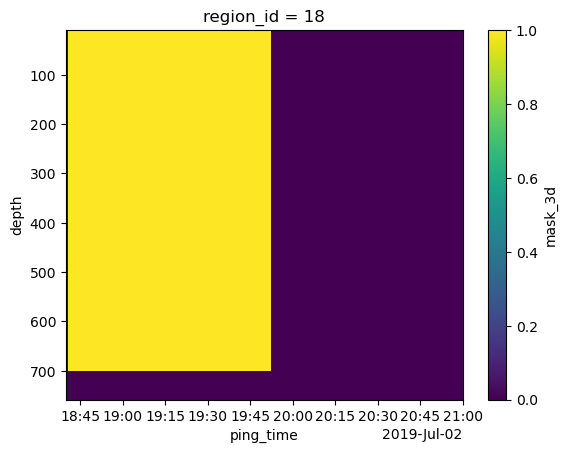

In [10]:
mask_3d_ds["mask_3d"].isel(region_id=1).plot(yincrease=False, y="depth")

In [11]:
mask_3d_ds_computed, _ = r2d.region_mask(
    da_Sv.compute(), mask_labels=mask_labels,
)

In [12]:
mask_3d_ds_computed.equals(mask_3d_ds)

/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 114.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/ctuguinay/miniforge3/envs/echoregions/lib/python3.12/site-packages/distributed/client.py:3370: UserWarning: Sending large graph of size 35.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


True